In [ ]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [ ]:
import network_flow_tracker.linking as NFTLinking
import network_flow_tracker.FlowGraph as FG
from network_flow_tracker import LFBFP

from network_flow_tracker.utils import io, vis

In [ ]:
data_group = 'Lightfield'
dataset = 'Zhang2020'
data_root_path = f'C:\\Data\\{data_group}\\{dataset}'
process_data_root = os.path.join(data_root_path, 'processed_data')
vis_folder_root = os.path.join(data_root_path, 'visualization')
vis_folder = os.path.join(vis_folder_root, 'simulation')
info_fp = os.path.join(process_data_root, 'data_info.pickle')
data_info = io.load_data(info_fp)
mm2s_to_pxl2s = 1e3 / data_info['frame_rate_Hz'] / data_info['target_voxel_size_um']

lfp = LFBFP.LFBFProcessing(data_root_path, data_info)
voxel_size_um = data_info['target_voxel_size_um']

In [ ]:
debug_Q = True
save_fig_Q = False
rm_node_voxel_on_vol_boundary_Q = True
z_idx = 1
z_folder_name = data_info['raw_data_folders'][z_idx]
vis_folder = os.path.join(vis_folder_root, 'method', z_folder_name)
vis_fp_prefix = f"{data_group}_{dataset}_{z_folder_name}"
data_folder = os.path.join(process_data_root, 'tracking')
data_fp = sorted(glob.glob(os.path.join(data_folder, f"{z_folder_name}_tk_w_pdt*")))
if len(data_fp) > 1: 
    data_fp = data_fp[-1]
else: 
    data_fp = data_fp[0]

tk_data = io.load_data(data_fp)
sv_data = tk_data['sv_data']
sv_disp_vec = sv_data['disp_vec']
mask_size = sv_data['mask_size']
vsl_im_vol = sv_data['im']
vsl_mips = vis.compute_three_view_mip(sv_data['im'])
vsl_mask = sv_data['label_array'] > 0

if 'graph_version' in tk_data:
    stitch_data_fp = tk_data['graph_version']
else: 
    raise ValueError("Unknown global graph version")
stitch_data = LFBFP.LFBFProcessing.load_and_parse_annotation_data(stitch_data_fp)
whole_mask_size = stitch_data['mask_size']

In [33]:
target_zoom = data_info['voxel_size_um'] / data_info['target_voxel_size_um']

### Single layer 3 view SMP

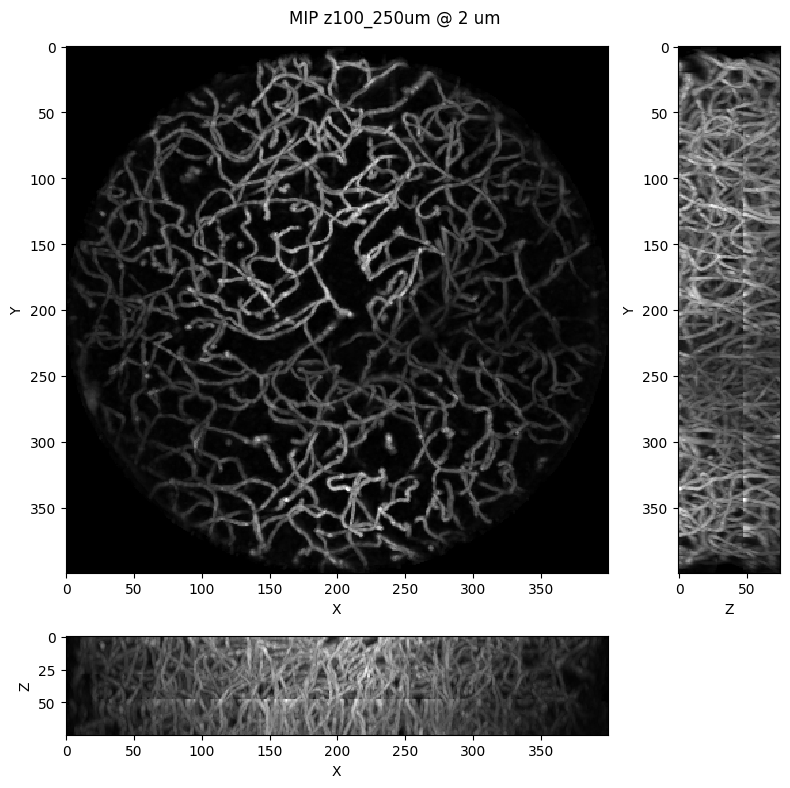

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_mip_3_views.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_mip_3_views.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_mip_3_views.png


In [ ]:
f = vis.vis_mips(vsl_mips, show_axes_Q=True, fig_title=f"MIP {z_folder_name} @ {voxel_size_um} um")
if save_fig_Q: 
    fp = os.path.join(vis_folder, f"Im_mip_3_views.png")
    io.print_image_in_several_formats(f, fp)

### Visualize single volume detection

In [ ]:
lfp = LFBFP.LFBFProcessing(data_root_path, data_info)
t_idx = 0
test_data = lfp.load_and_preprocess_raw_data_to_match_mask(z_idx, t_idx) # (75, 400, 400), circular masked
raw_data_mips = vis.compute_three_view_mip(test_data + 1) # + 1 for log visualization

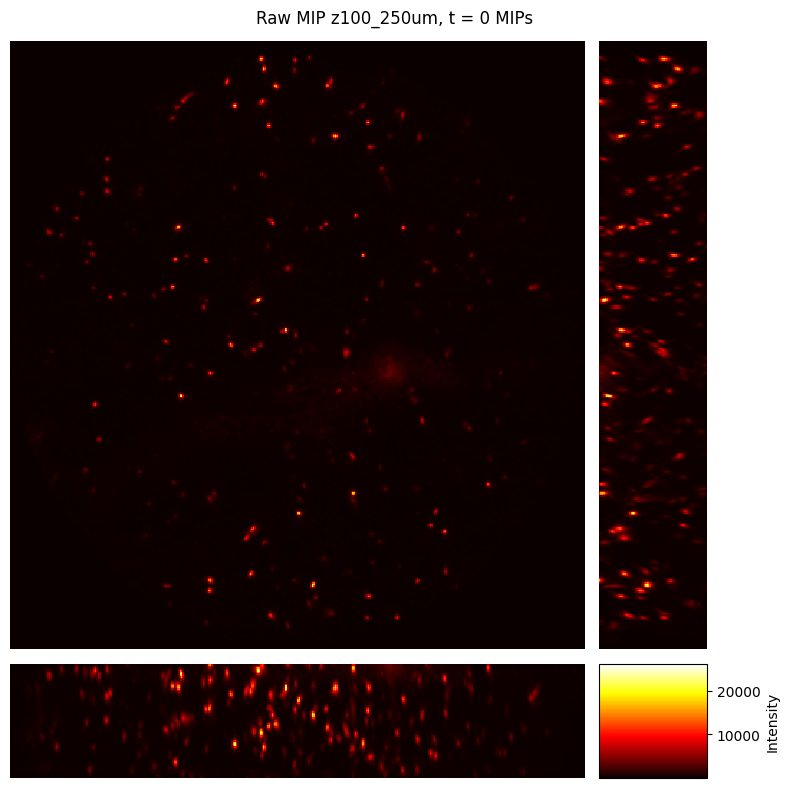

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_t_0_3_views_cmap_hot.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_t_0_3_views_cmap_hot.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_t_0_3_views_cmap_hot.png


In [56]:
f, ax_yx, ax_yz, ax_zx, ax_blank = vis.vis_3_view_mip(raw_data_mips, colorbarQ=True, cbar_label='Intensity', show_axes_Q=False, 
                                            fig_title=f"Raw MIP {data_info['raw_data_folders'][z_idx]}, t = {t_idx} MIPs", cmap='hot', visQ=True)
if save_fig_Q or True: 
    fp = os.path.join(vis_folder, f"Im_t_{t_idx}_3_views_cmap_hot.png")
    io.print_image_in_several_formats(f, fp)

In [61]:
para = {}
para['dog_sig1'] = 0
para['dog_sig2'] = (2, 2, 2)
para['bg_vxl_f'] = 0.95
para['bg_est_sample_step'] = 10
para['min_peak_snr'] = 5
para['bg_max_int'] = 500
para['min_peak_dist'] = 3
para['peak_int_diff_sm_wd'] = 10
para['peak_int_diff_th'] = 1
para['nb_wd_r'] = (2, 2, 2)
para['nb_bg_min_dist'] = np.sqrt(5)

nb_features, info = LFBFP.Detection.process_single_volume(test_data, para)
nb_features['info'] = info | para

In [28]:
tmp_peak_snr = nb_features['peak_nb_snr']
vis_Q = tmp_peak_snr > 2
vis_sub = (nb_features['pos'][vis_Q, 0], nb_features['pos'][vis_Q, 1], nb_features['pos'][vis_Q, 2])
vis_snr = tmp_peak_snr[vis_Q]

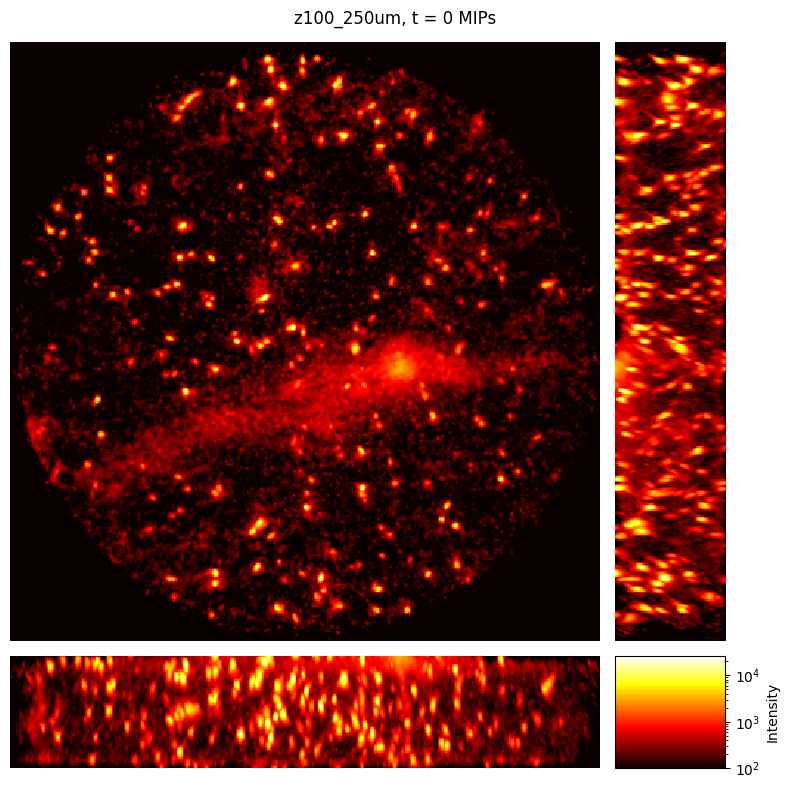

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_t_0_3_views_cmap_hot_log_vmin_100.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_t_0_3_views_cmap_hot_log_vmin_100.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_t_0_3_views_cmap_hot_log_vmin_100.png


In [76]:
# mip_c_min = np.round(info['int_th'])
mip_c_min = 100
f, ax_yx, ax_yz, ax_zx, ax_blank = vis.vis_3_view_mip(raw_data_mips, colorbarQ=True, cbar_label='Intensity', show_axes_Q=False, 
                                            fig_title=f"{data_info['raw_data_folders'][z_idx]}, t = {t_idx} MIPs", cmap='hot', visQ=True, 
                                            c_scale='log', v_min=mip_c_min)
if save_fig_Q or True: 
    fp = os.path.join(vis_folder, f"Im_t_{t_idx}_3_views_cmap_hot_log_vmin_{mip_c_min}.png")
    io.print_image_in_several_formats(f, fp)

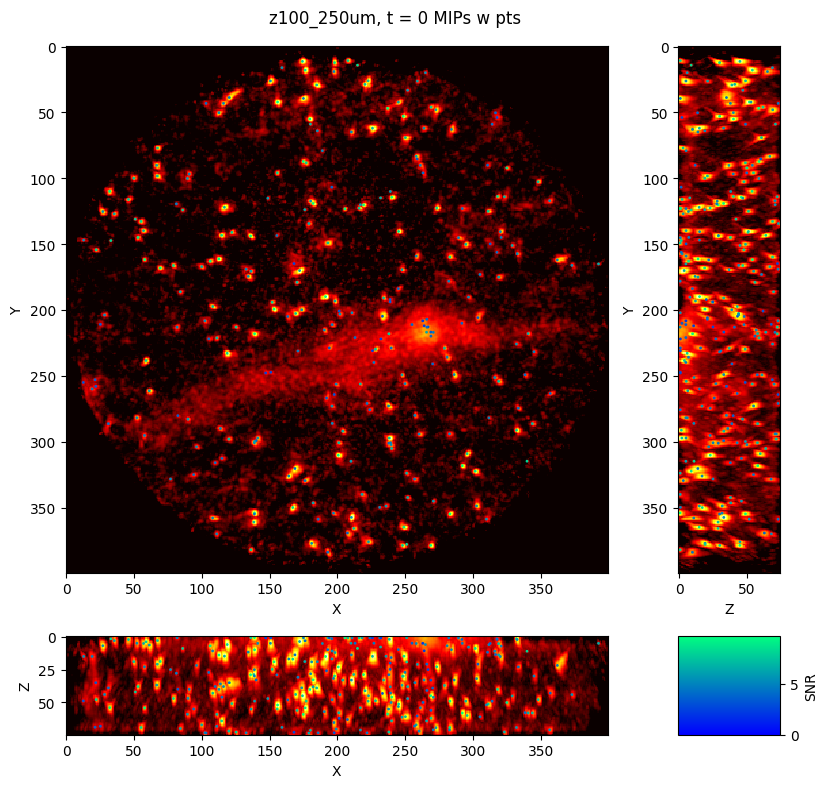

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_t_0_3_views_cmap_hot_log_vmin_100_w_pts.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_t_0_3_views_cmap_hot_log_vmin_100_w_pts.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Im_t_0_3_views_cmap_hot_log_vmin_100_w_pts.png


In [77]:
f, ax_yx, ax_yz, ax_zx, ax_blank = vis.vis_3_view_mip(raw_data_mips, colorbarQ=False, cbar_label='Intensity', show_axes_Q=True, 
                                            fig_title=f"{data_info['raw_data_folders'][z_idx]}, t = {t_idx} MIPs w pts", cmap='hot', visQ=False, 
                                            c_scale='log', v_min=mip_c_min)
ax_blank.set_visible(True)
sc = ax_yx.scatter(vis_sub[2], vis_sub[1], s=1, c=vis_snr, vmin=0, vmax=np.percentile(vis_snr, 95), cmap='winter')
sc = ax_yz.scatter(vis_sub[0], vis_sub[1], s=1, c=vis_snr, vmin=0, vmax=np.percentile(vis_snr, 95), cmap='winter')
sc = ax_zx.scatter(vis_sub[2], vis_sub[0], s=1, c=vis_snr, vmin=0, vmax=np.percentile(vis_snr, 95), cmap='winter')
f.colorbar(sc, cax=ax_blank, label='SNR')
plt.show()

if save_fig_Q or True: 
    fp = os.path.join(vis_folder, f"Im_t_{t_idx}_3_views_cmap_hot_log_vmin_{mip_c_min}_w_pts.png")
    io.print_image_in_several_formats(f, fp)

### Flow speed estimation

### Theoretical analysis

In [5]:
rRBC = 2
rbcVfrac = 0.45

In [14]:
fun_dfs = lambda gamma : (4 * np.pi /(3 * gamma * rbcVfrac)) ** (1/3) * rRBC

gamma_list = np.logspace(np.log10(1e-3), np.log10(1), 100)
dfs_list = fun_dfs(gamma_list)

def avg_dist(vsl_r_um, gamma): 
    dfs = fun_dfs(gamma)
    vsl_d_um = vsl_r_um * 2
    if dfs > 2 * vsl_r_um: 
        d = (2 * np.pi) * (dfs / vsl_d_um) ** 2 * dfs
    else: 
        d = 0.556 * dfs
    return d

def avg_dist_vec(gamma, vsl_r_um):
    gamma = np.asarray(gamma)
    vsl_r_um = np.asarray(vsl_r_um)
    dfs = fun_dfs(gamma)
    vsl_d_um = vsl_r_um * 2
    small_Q = dfs > 2 * vsl_r_um
    small_idx = np.nonzero(small_Q.flatten())
    large_idx = np.nonzero(~small_Q.flatten())
    result = np.zeros(small_Q.shape)
    result.flat[small_idx] = (2 * np.pi) * (dfs.flat[small_idx] / vsl_d_um.flat[small_idx]) ** 2 * dfs.flat[small_idx]
    result.flat[large_idx] = 0.556 * dfs.flat[large_idx]
    return result    

In [7]:
from matplotlib.colors import LogNorm

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_avg_min_dist_vs_vsl_rad_and_label_fraction.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_avg_min_dist_vs_vsl_rad_and_label_fraction.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_avg_min_dist_vs_vsl_rad_and_label_fraction.png


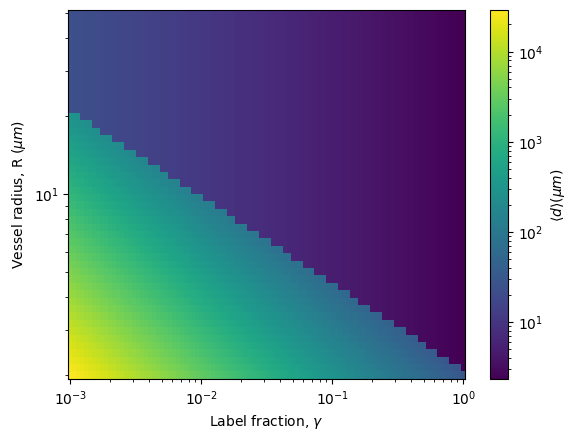

In [26]:
vsl_r_list = np.logspace(np.log10(2), np.log10(50), 50)
gamma_map, vsl_r_map = np.meshgrid(gamma_list, vsl_r_list, indexing='ij')
avg_d_map = avg_dist_vec(gamma_map, vsl_r_map)
f, a = plt.subplots()
im = a.pcolormesh(gamma_map, vsl_r_map, avg_d_map,  norm=LogNorm())
a.set_xscale('log')
a.set_yscale('log')
cb = f.colorbar(im)
cb.set_label('$\langle d \\rangle (\mu m)$')
a.set_xlabel('Label fraction, $\gamma$')
a.set_ylabel('Vessel radius, R ($\mu m$)')
fp = os.path.join(vis_folder, f"Theory_avg_min_dist_vs_vsl_rad_and_label_fraction.png") 
io.print_image_in_several_formats(f, fp)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_avg_d_vs_label_fraction.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_avg_d_vs_label_fraction.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_avg_d_vs_label_fraction.png


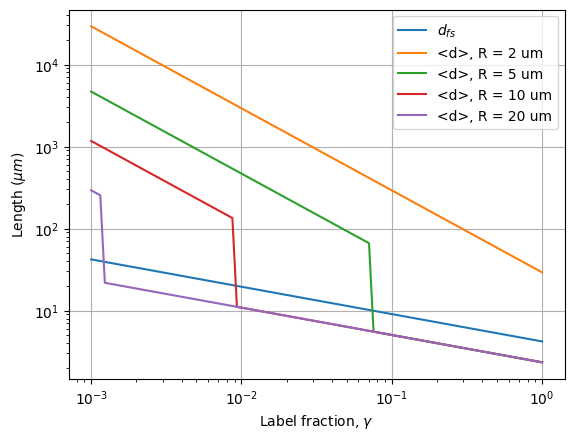

In [27]:
f, a = plt.subplots()
a.plot(gamma_list, dfs_list, label='$d_{fs}$')
avg_d_dict = {}
for tmp_r in [2, 5, 10, 20]: 
    avg_d_dict[tmp_r] = avg_dist_vec(gamma_list, tmp_r * np.ones(gamma_list.shape))
    a.plot(gamma_list, avg_d_dict[tmp_r], label=f'<d>, R = {tmp_r} um')
a.set_xscale('log')
a.set_yscale('log')
a.grid()
a.set_xlabel('Label fraction, $\gamma$')
a.set_ylabel('Length ($\mu m$)')
a.legend()
fp = os.path.join(vis_folder, f"Theory_avg_d_vs_label_fraction.png")
io.print_image_in_several_formats(f, fp)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_vmax_vs_label_fraction_var_vsl_R.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_vmax_vs_label_fraction_var_vsl_R.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_vmax_vs_label_fraction_var_vsl_R.png


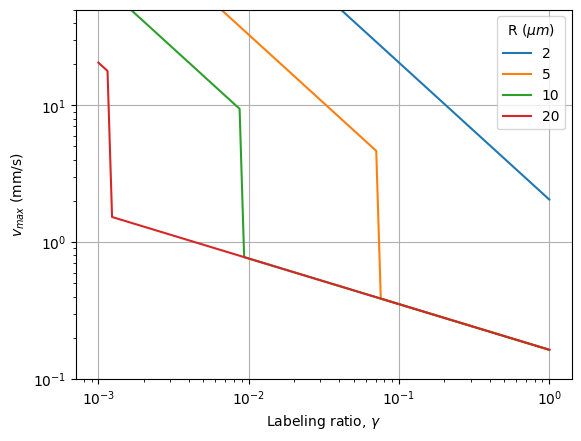

In [ ]:
fun_vmax_from_d = lambda facq, d, eps: facq * d / eps / 1000
f_acq_Hz = 70
vmax_d = {k: fun_vmax_from_d(f_acq_Hz, v, 1) for k, v in avg_d_dict.items()}

f = plt.figure()
a = f.add_subplot()
for k, v in vmax_d.items(): 
    a.plot(gamma_list, v, label=f"{k}")
a.set_xscale('log')
a.set_yscale('log')
a.set_xlabel("Labeling ratio, $\gamma$")
a.set_ylabel("$v_{max}$ (mm/s)")
a.set_ylim(0.1, 50)
a.grid()
a.legend(title=f"R ($\mu m$)", loc='best')

fp = os.path.join(vis_folder, f"Theory_vmax_vs_label_fraction_var_vsl_R.png")
io.print_image_in_several_formats(f, fp)
# a1 = f.add_subplot(2, 1, 2)
# a1.plot(gamma_list, measure_f_d[2], '--', label=f"2")
# # # for k, v in measure_f_d.items(): 
# # #     a1.plot(gamma_list, v, '--', label=f"{k}")
# a1.set_yscale('log')
# a1.set_xscale('log')
# a1.set_ylabel('Microvessel measurement frequency, f_m (Hz)')

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_fmeasure_vs_label_fraction_var_speed_vsl_R_2_um.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_fmeasure_vs_label_fraction_var_speed_vsl_R_2_um.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_fmeasure_vs_label_fraction_var_speed_vsl_R_2_um.png
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_measure_period_vs_label_fraction_var_speed_vsl_R_2_um.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_measure_period_vs_label_fraction_var_speed_vsl_R_2_um.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/Theory_measure_period_vs_label_fraction_var_speed_vsl_R_2_um.png


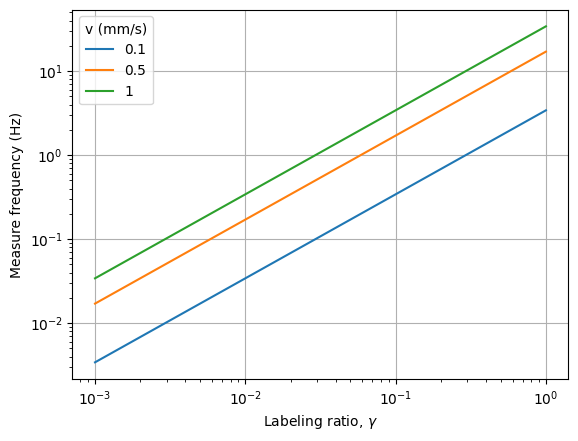

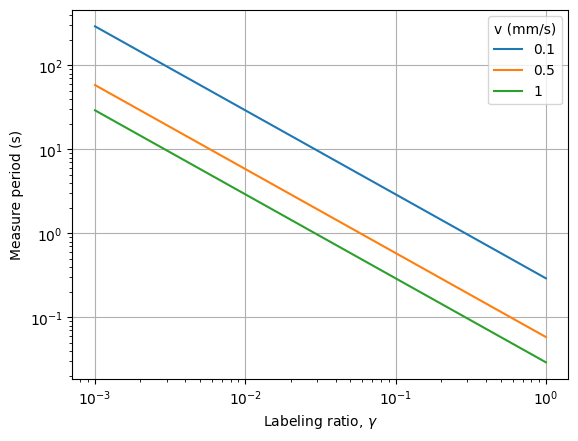

In [31]:
fun_measureFeq_from_d = lambda d, vmin: vmin * 1000  / d
measure_f_d = {v: fun_measureFeq_from_d(avg_d_dict[2], v) for v in [0.1, 0.5, 1]}

f = plt.figure()
a = f.add_subplot()
for k, v in measure_f_d.items(): 
    a.plot(gamma_list, v, label=f"{k}")
a.set_xscale('log')
a.set_yscale('log')
a.set_xlabel("Labeling ratio, $\gamma$")
a.set_ylabel("Measure frequency (Hz)")
# a.set_ylim(0.1, 50)
a.grid()
a.legend(title=f"v (mm/s)", loc='best')
fp = os.path.join(vis_folder, f"Theory_fmeasure_vs_label_fraction_var_speed_vsl_R_2_um.png")
io.print_image_in_several_formats(f, fp)

f = plt.figure()
a = f.add_subplot()
for k, v in measure_f_d.items(): 
    a.plot(gamma_list, 1/v, label=f"{k}")
a.set_xscale('log')
a.set_yscale('log')
a.set_xlabel("Labeling ratio, $\gamma$")
a.set_ylabel("Measure period (s)")
# a.set_ylim(0.1, 50)
a.grid()
a.legend(title=f"v (mm/s)", loc='best')
fp = os.path.join(vis_folder, f"Theory_measure_period_vs_label_fraction_var_speed_vsl_R_2_um.png")
io.print_image_in_several_formats(f, fp)

In [ ]:
fun_vmax = lambda facq, gamma, eps: (2 * facq * rRBC) / ((rbcVfrac * gamma) ** (1/3) * eps * 1000)
fun_measureFeq = lambda gamma, vmin: (rbcVfrac * gamma * vmin * 1000) / (2 * rRBC)

In [52]:
gamma_list = np.logspace(np.log10(0.0001), np.log10(0.1), 100)
vmax_para_list = [(70, 1), (70, 0.25), (200, 0.25), (400, 1)]
vmax_list = [fun_vmax(k[0], gamma_list, k[1]) for k in vmax_para_list]
measureFeq_para_list = [0.1, 0.5, 1]
measureFeq_list = [fun_measureFeq(gamma_list, k) for k in measureFeq_para_list]

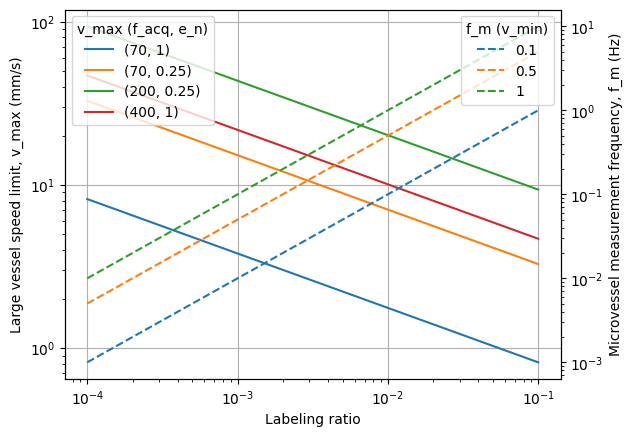

In [57]:
f = plt.figure()
a = f.add_subplot()
for i, v in enumerate(vmax_list): 
    a.plot(gamma_list, v, label=f"{vmax_para_list[i]}")
a.set_xscale('log')
a.set_yscale('log')
a.set_xlabel("Labeling ratio")
a.set_ylabel("Large vessel speed limit, v_max (mm/s)")
a.grid()
a1 = a.twinx()
for i, v in enumerate(measureFeq_list): 
    a1.plot(gamma_list, v, '--', label=f"{measureFeq_para_list[i]}")
a1.set_yscale('log')
a1.set_ylabel('Microvessel measurement frequency, f_m (Hz)')

a.legend(title=f"v_max (f_acq, e_n)", loc='upper left')
a1.legend(title=f"f_m (v_min)", loc='upper right')

In [58]:
fp = os.path.join(vis_folder, 'tracking_limit', 'vmax3d_and_f_e_vs_labeling_ratio.png')
io.print_image_in_several_formats(f, fp)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/tracking_limit/vmax3d_and_f_e_vs_labeling_ratio.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/tracking_limit/vmax3d_and_f_e_vs_labeling_ratio.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um/tracking_limit/vmax3d_and_f_e_vs_labeling_ratio.png


In [41]:
1 / (54 ** 3)

6.350657928161357e-06